In [68]:
#install numpy, pandas, matplolib, tensorflow, sklearn, pandas_datareader, seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from time import sleep
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

import seaborn as sns
import pandas_datareader as pd_dr

In [69]:
#Données d'entrainement doivent être différentes des données de test donc on s'arrete en 2019...
training_data = pd_dr.DataReader( 'BTC-USD', 'yahoo', dt.datetime(2015,1,1), dt.datetime(2020,12,30) )
testing_data = pd_dr.DataReader( 'BTC-USD', 'yahoo', dt.datetime(2021,1,1), dt.datetime.now() )
#Drop la adj Close

In [70]:
trend_training_data = training_data
trend_testing_data = testing_data

In [71]:
#trend preprocessing
trend_training_data_j1 = trend_training_data.shift(periods=1)
trend_testing_data_j1 = trend_testing_data.shift(periods=1)

#creation de la colonne tendance, dans laquelle on soustrait le prix du jour actuel au prix j-1
trend_training_data['Diff_J+1'] = trend_training_data["Close"] - trend_training_data_j1["Close"]
trend_testing_data['Diff_J+1'] = trend_testing_data["Close"] - trend_testing_data_j1["Close"]

#dans la colonne tendance, on remplace toutes les tendance de prix par True si elles augmentent et par False si elle diminue
trend_training_data["Diff_J+1"].loc[trend_training_data["Diff_J+1"] >= 0] = True
trend_training_data["Diff_J+1"].loc[trend_training_data["Diff_J+1"] < 0] = False

trend_testing_data["Diff_J+1"].loc[trend_testing_data["Diff_J+1"] >= 0] = True
trend_testing_data["Diff_J+1"].loc[trend_testing_data["Diff_J+1"] < 0] = False

#suppression des lignes avec NaN (la premiere n'a pas de tendance vu qu'on a pas de jour precedent
#on supprime la ligne plutot que de mettre une donnée fausse car il y'a 2192 lignes)
trend_training_data.dropna(subset = ["Diff_J+1"], inplace=True)

trend_training_data["Diff_J+1"]= trend_training_data["Diff_J+1"].astype('bool')
trend_testing_data["Diff_J+1"]= trend_testing_data["Diff_J+1"].astype('bool')

C:\Users\owcha\AppData\Local\Temp\ipykernel_5692\2998757128.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend_training_data["Diff_J+1"].loc[trend_training_data["Diff_J+1"] >= 0] = True
C:\Users\owcha\AppData\Local\Temp\ipykernel_5692\2998757128.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend_testing_data["Diff_J+1"].loc[trend_testing_data["Diff_J+1"] >= 0] = True


In [72]:
print( trend_training_data['Diff_J+1'].value_counts() )
print( trend_testing_data['Diff_J+1'].value_counts() )

True     1208
False     983
Name: Diff_J+1, dtype: int64
True     221
False    215
Name: Diff_J+1, dtype: int64


In [77]:
print( trend_training_data.shape )

trend_training_x = trend_training_data.drop(columns=['Diff_J+1'])
print( trend_training_x.shape )
trend_training_y = trend_training_data['Diff_J+1']
print( trend_training_y.shape )


trend_testing_x = trend_testing_data.drop(columns=['Diff_J+1'])
print( trend_testing_x.shape )
trend_testing_y = trend_testing_data['Diff_J+1']
print( trend_testing_y.shape )

trend_scaler = MinMaxScaler( feature_range=(0,1) ) 
trend_training_x = trend_scaler.fit_transform(trend_training_x)
trend_testing_x = trend_scaler.fit_transform(trend_testing_x)

(2191, 7)
(2191, 6)
(2191,)
(436, 6)
(436,)


In [80]:
#Random Forest Model
model = RandomForestClassifier(criterion = 'entropy', max_depth=30)
model.fit( trend_training_x, trend_training_y )

RandomForestClassifier(criterion='entropy', max_depth=30)

0.7958715596330275
              precision    recall  f1-score   support

       False       0.88      0.68      0.77       215
        True       0.74      0.91      0.82       221

    accuracy                           0.80       436
   macro avg       0.81      0.79      0.79       436
weighted avg       0.81      0.80      0.79       436



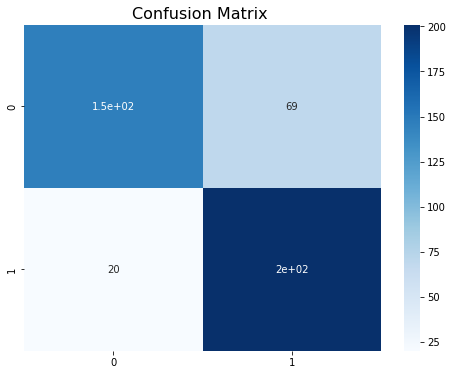

In [82]:
print( model.score( trend_testing_x, trend_testing_y ) )

trend_prediction = model.predict( trend_testing_x )

cm = confusion_matrix( trend_testing_y , trend_prediction )
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix ', size=16)
sns.heatmap(cm, annot=True, cmap='Blues')

print( classification_report( trend_testing_y , trend_prediction ) )